### Lading the Data

In [1]:
DATA_DIR = "../input/animefacedataset/"

In [2]:
import os
os.listdir(DATA_DIR)

['images']

In [3]:
os.listdir(DATA_DIR + '/images')[:10]

['28042_2009.jpg',
 '44551_2013.jpg',
 '42026_2013.jpg',
 '14305_2006.jpg',
 '38510_2012.jpg',
 '48157_2014.jpg',
 '21532_2008.jpg',
 '2435_2001.jpg',
 '25866_2009.jpg',
 '58758_2017.jpg']

In [4]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [5]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [6]:
train_ds = ImageFolder(DATA_DIR, transform = T.Compose([
                        T.Resize(image_size),
                        T.CenterCrop(image_size),
                        T.ToTensor(),
                        T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

### Helper function to denormalize the image tensors

In [7]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [9]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1,2, 0))
    
def show_batch(dl ,nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

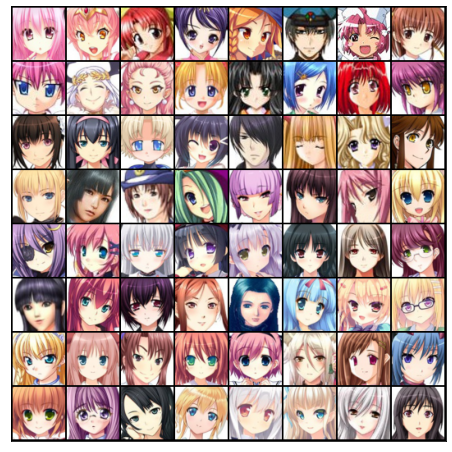

In [10]:
show_batch(train_dl)

### Using a GPU

In [11]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [12]:
device = get_default_device()
device

device(type='cuda')

In [13]:
train_dl = DeviceDataLoader(train_dl , device)

### Discriminator Network

In [14]:
import torch.nn as nn

In [15]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64
    
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    #out: 128 x 16 x 16
    
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    #out: 256 x 8 x 8
    
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    #out: 512 x 4 x 4
    
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    #out: 1 x 1 x 1
    
    nn.Flatten(),
    nn.Sigmoid())

In [16]:
discriminator = to_device(discriminator, device)

In [17]:
latent_size = 128

In [18]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4
    
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    #out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    #out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    #out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


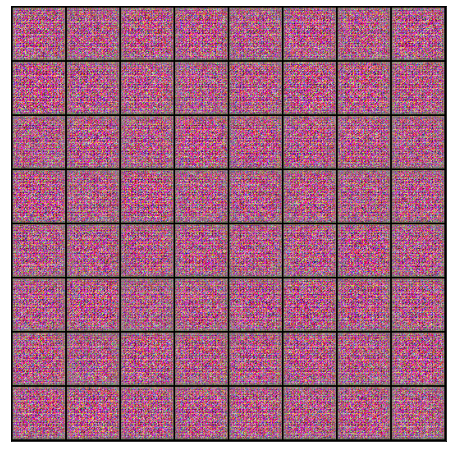

In [19]:
# Let's generate some outputs using the generator and view them as images by transforming and denormalizing the output.

xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [20]:
generator = to_device(generator, device)

In [43]:
def train_discriminator(real_images, opt_d):
    #clear discriminator gradients
    opt_d.zero_grad()
    
    #pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    #generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    #pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()
    
    #update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [44]:
def train_generator(opt_g):
    #clear generator gradients
    opt_g.zero_grad()
    
    #generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    #Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    #update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

Create a directory to save intermediate outputs from the generator to visually inspect the progress of the model. Also create a helper function to export the generated images.

In [45]:
from torchvision.utils import save_image

In [46]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [47]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model. Let's save one set of images before we start training our model.

In [48]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


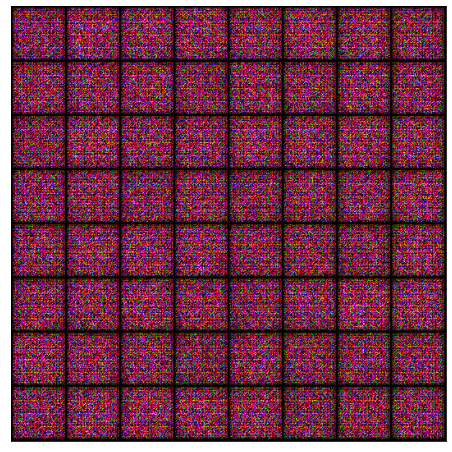

In [49]:
save_samples(0, fixed_latent)

## Full Training Loop

Let's define a `fit` function to train the discriminator and generator in tandem for each batch of training data. We'll use the Adam optimizer. We will also save some sample generated images at regular intervals for inspection.

In [50]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [51]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
                epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
        
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
        
    return losses_g, losses_d, real_scores, fake_scores

In [52]:
lr = 0.0002
epochs = 25

In [53]:
history = fit(epochs, lr)


Epoch [1/25], loss_g: 6.6354, loss_d: 0.8184, real_score: 0.9220, fake_score: 0.4927
Saving generated-images-0001.png



Epoch [2/25], loss_g: 3.6943, loss_d: 0.4527, real_score: 0.8187, fake_score: 0.1565
Saving generated-images-0002.png



Epoch [3/25], loss_g: 6.2144, loss_d: 0.5583, real_score: 0.9545, fake_score: 0.3488
Saving generated-images-0003.png



Epoch [4/25], loss_g: 6.5017, loss_d: 0.3712, real_score: 0.8958, fake_score: 0.2000
Saving generated-images-0004.png



Epoch [5/25], loss_g: 4.3743, loss_d: 0.3571, real_score: 0.7819, fake_score: 0.0230
Saving generated-images-0005.png



Epoch [6/25], loss_g: 9.1993, loss_d: 0.6651, real_score: 0.9410, fake_score: 0.4047
Saving generated-images-0006.png



Epoch [7/25], loss_g: 3.2049, loss_d: 0.1447, real_score: 0.9225, fake_score: 0.0467
Saving generated-images-0007.png



Epoch [8/25], loss_g: 7.6171, loss_d: 0.3827, real_score: 0.9787, fake_score: 0.2719
Saving generated-images-0008.png



Epoch [9/25], loss_g: 3.8992, loss_d: 0.2210, real_score: 0.9039, fake_score: 0.1013
Saving generated-images-0009.png



Epoch [10/25], loss_g: 1.9685, loss_d: 0.3144, real_score: 0.7856, fake_score: 0.0224
Saving generated-images-0010.png



Epoch [11/25], loss_g: 3.9477, loss_d: 0.1164, real_score: 0.9549, fake_score: 0.0641
Saving generated-images-0011.png



Epoch [12/25], loss_g: 5.9902, loss_d: 0.2732, real_score: 0.9647, fake_score: 0.1952
Saving generated-images-0012.png



Epoch [13/25], loss_g: 4.0221, loss_d: 0.1648, real_score: 0.9137, fake_score: 0.0629
Saving generated-images-0013.png



Epoch [14/25], loss_g: 3.9383, loss_d: 0.1403, real_score: 0.9298, fake_score: 0.0589
Saving generated-images-0014.png



Epoch [15/25], loss_g: 4.1421, loss_d: 0.2071, real_score: 0.9340, fake_score: 0.1169
Saving generated-images-0015.png



Epoch [16/25], loss_g: 4.9923, loss_d: 0.3749, real_score: 0.8130, fake_score: 0.0992
Saving generated-images-0016.png



Epoch [17/25], loss_g: 6.3165, loss_d: 0.4305, real_score: 0.9763, fake_score: 0.3008
Saving generated-images-0017.png



Epoch [18/25], loss_g: 4.4086, loss_d: 0.1115, real_score: 0.9558, fake_score: 0.0566
Saving generated-images-0018.png



Epoch [19/25], loss_g: 3.7608, loss_d: 0.2099, real_score: 0.8833, fake_score: 0.0652
Saving generated-images-0019.png



Epoch [20/25], loss_g: 5.0052, loss_d: 0.1227, real_score: 0.9638, fake_score: 0.0766
Saving generated-images-0020.png



Epoch [21/25], loss_g: 5.9614, loss_d: 0.3674, real_score: 0.9870, fake_score: 0.2496
Saving generated-images-0021.png



Epoch [22/25], loss_g: 3.1590, loss_d: 0.1266, real_score: 0.9305, fake_score: 0.0421
Saving generated-images-0022.png



Epoch [23/25], loss_g: 5.4971, loss_d: 0.1439, real_score: 0.9667, fake_score: 0.0948
Saving generated-images-0023.png



Epoch [24/25], loss_g: 4.8537, loss_d: 0.0735, real_score: 0.9637, fake_score: 0.0340
Saving generated-images-0024.png



Epoch [25/25], loss_g: 3.8546, loss_d: 0.2720, real_score: 0.9949, fake_score: 0.1981
Saving generated-images-0025.png


In [63]:
losses_g, losses_d, real_scores, fake_scores = history

In [54]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')

In [55]:
from IPython.display import Image

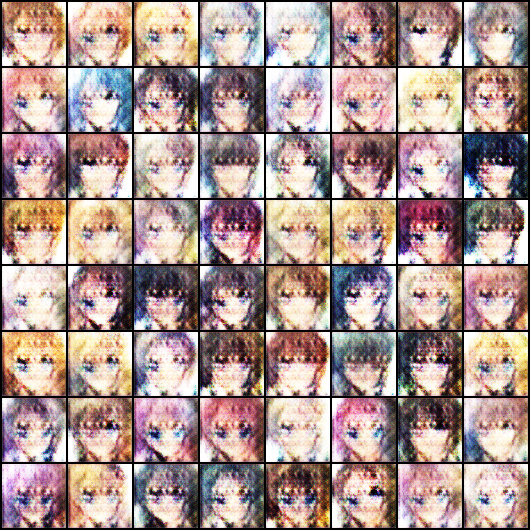

In [56]:
Image('./generated/generated-images-0001.png')

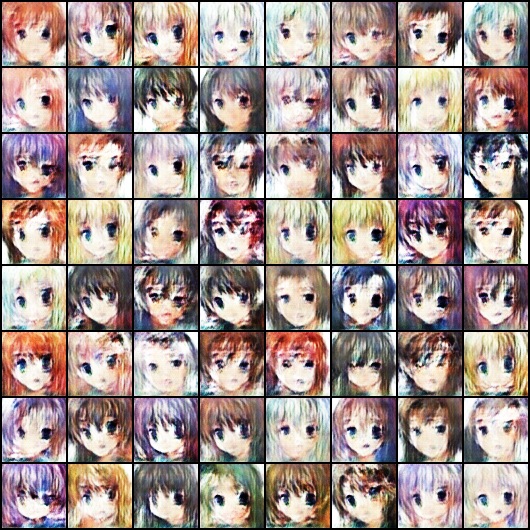

In [57]:
Image('./generated/generated-images-0005.png')

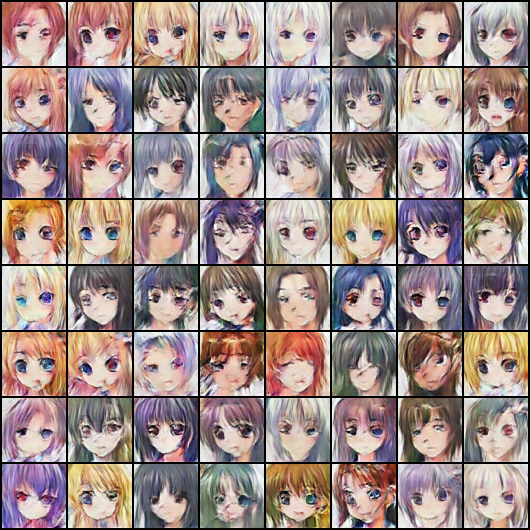

In [58]:
Image('./generated/generated-images-0010.png')

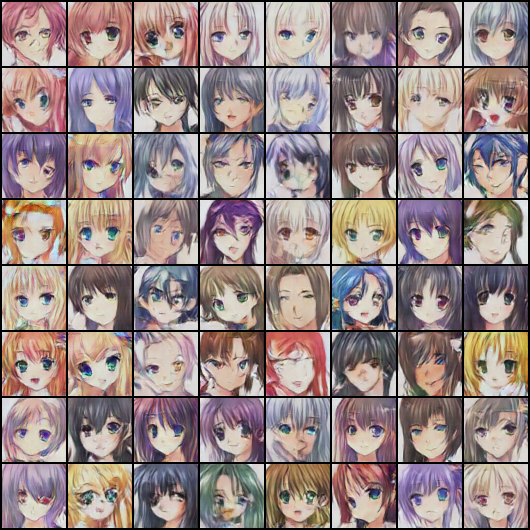

In [59]:
Image('./generated/generated-images-0020.png')

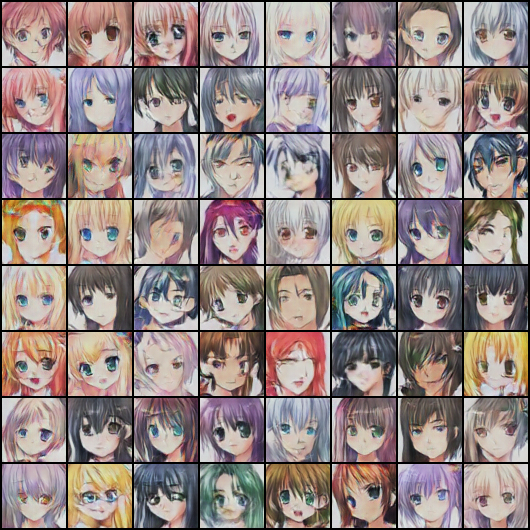

In [60]:
Image('./generated/generated-images-0025.png')

We can visualize the training process by combining the sample images generated after each epoch into a video using OpenCV.

In [61]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

Visualizing the losses

Text(0.5, 1.0, 'Losses')

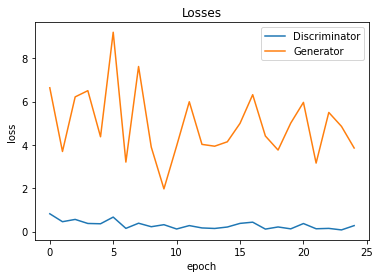

In [64]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

Text(0.5, 1.0, 'Scores')

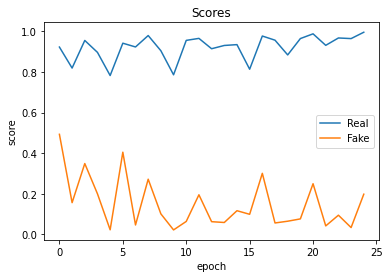

In [65]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores')